<a href="https://colab.research.google.com/github/pskaranth/encoder-decoder/blob/main/BMS_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data and Task
The data is from a competition in Kaggle by Bristol-Myers Squibb :

https://www.kaggle.com/c/bms-molecular-translation/data

Task is to predict the chemical formula (Inchi Code) from a set of training images provided. (Inchi - International Chemical Identifier)

<b>About the model</b>

>There are millions of images in the training data and test data. Notebook utilizes GPU if available for faster execution. Also, have used just the training data due to memory constraints with GPU in colab.

>Used a Encoder-Decoder architecture with attention for the model.

<b>References</b>

https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter

https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning

Padhai-Onefourthlabs for Attention mechanism.



In [ ]:
#Downloaded Kaggle Dataset from the above 
%cd /content/drive/MyDrive/Kaggle/BristolMeyers/

/content/drive/MyDrive/Kaggle/BristolMeyers


# Loading the dataset

In [ ]:
#Load the Dataset
%%time
DATA_PATH = './bms-molecular-translation/'
!mkdir {DATA_PATH}
!unzip -q bms-molecular-translation.zip "train/**/*" -d '/content/bms-molecular-translation/'

mkdir: cannot create directory ‘./bms-molecular-translation/’: File exists
CPU times: user 2.05 s, sys: 348 ms, total: 2.4 s
Wall time: 6min 22s


In [ ]:
!unzip -q bms-molecular-translation.zip "train_labels.csv" -d '/content/bms-molecular-translation/'

In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A

import pandas as pd
import numpy as np
import re

from tqdm.auto import tqdm
tqdm.pandas()

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from torchvision import models
import torchvision
import torchvision.transforms as transforms


from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

from IPython.display import clear_output

# Instantiates the device to be used as GPU/CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
train = pd.read_csv('/content/bms-molecular-translation/train_labels.csv')

In [ ]:
print(train.shape)

(2424186, 2)


In [ ]:
train.head()

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


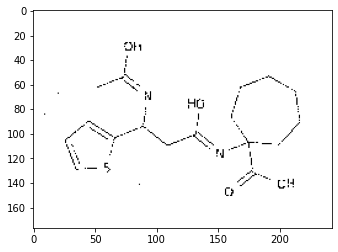

In [ ]:
image = cv2.imread('/content/bms-molecular-translation/train/0/0/0/000026b49b7e.png') #C19H22Br2N2O2
plt.imshow(image)

#Encoding the target labels

In [ ]:
#InChI=1S/C15H22N4/c1-12(2)10-19(11-13-5-3-7-17-13)15-6-4-8-18-14(15)9-16/h4,6,8,12-13,17H,3,5,7,10-11H2,1-2
#Converting Inchi codes to List
def codetolist(InChI_):
   i =InChI_.split('=')
   j =i[1].split('/') 

   element_rep = []

   temp= re.findall(r"[A-Z][a-z]*|\d+", j[1]) #finds all elements matching the string for example'Aaa'
   for i_ in temp:
     element_rep.append(i_)
        
   for  layers in j[2:]:
      #  print(layers)
    
     ele_sec = re.findall(r"[A-Za-z]|\d+|[-()+,]", layers) #for sub layers
     element_rep.append('/')
     for j_ in ele_sec:      
       element_rep.append(j_)    
    
  #  print(element_rep)
   return element_rep

In [ ]:
def convertToLabel(train_label):
  numcodes=set()  
  elementCodes= []
  code = {'H'	, 'He',	 'Li',	 'Be',	 'B'	, 'C'	, 'N'	, 'O'	, 'F'	, 'Ne',	 'Na',	 'Mg',	
'Al',	 'Si',	 'P'	 ,    'S'	 ,    'Cl',	 'Ar',	 'K'	 ,    'Ca',	 'Sc',	 'Ti',	
'V'	 ,    'Cr',	 'Mn',	 'Fe',	 'Co',	 'Ni',	 'Cu',	 'Zn',	 'Ga',	 'Ge',	
'As',	 'Se',	 'Br',	 'Kr',	 'Rb',	 'Sr',	 'Y'	 ,    'Zr',	 'Nb',	 'Mo',	
'Tc',	 'Ru',	 'Rh',	 'Pd',	 'Ag',	 'Cd',	 'In',	 'Sn',	 'Sb',	 'Te',	 'I'	 ,  
 'Xe',	 'Cs',	 'Ba',	 'La',	 'Ce',	 'Pr',	 'Nd',	 'Pm',	 'Sm',	 'Eu',	 'Gd',	
'Tb',	 'Dy',	 'Ho',	 'Er',	 'Tm',	 'Yb',	 'Lu',	 'Hf',	 'Ta',	 'W'	 ,   
'Re',	 'Os',	 'Ir',	 'Pt',	 'Au',	 'Hg',	 'Tl',	 'Pb',	 'Bi',	 'Po',	 'At',	
'Rn',	 'Fr',	 'Ra',	 'Ac',	 'Th',	 'Pa',	 'U'	 ,    'Np',	 'Pu',	 'Am',	
'Cm',	 'Bk',	 'Cf',	 'Es',	 'Fm',	 'Md',	 'No',	 'Lr',	 'Rf',	 'Db',	 'Sg',	
'Bh',	 'Hs',	 'Mt',	 'Ds',	 'Rg',	 'Cn',	 'Uut' ,	 'Fl' ,		'Uup', 'Lv',	
'Uus',	 'Uuo'}
  numcodes.update({'sop'})
  numcodes.update({'-pad-'})
  numcodes.update(code) 
  numcodes.update({'/'}) # representing each layers

  for label in train_label:
   numcodes.update(codetolist(label))

  elementCodes = list(numcodes)
  elementCodes.append('eop')
  return elementCodes

In [ ]:
elementCodes = convertToLabel(train['InChI'])

In [ ]:
def sequence_rep(InChI_list, numcodes, device = 'cpu'):   
    rep = torch.zeros(len(InChI_list)+1).to(device)
        
    for code_index_, letter_ in enumerate(InChI_list):
      # print(letter_)
      pos = numcodes.index(letter_)
      rep[0] = numcodes.index('sop')
      rep[code_index_+1] = pos   
    rep[len(InChI_list)] =   numcodes.index('eop')
    return rep

In [ ]:
label = 'InChI=1S/C13H12BrF3N4OS/c14-8-4-9(23-6-8)12(22)18-5-11-20-19-10-3-7(13(15,16)17)1-2-21(10)11/h4,6-7H,1-3,5H2,(H,18,22)/t7-/m0/s1'
listofcodes= codetolist(label)

In [ ]:
label = 'InChI=1S/C13H12BrF3N4OS/c14-8-4-9(23-6-8)12(22)18-5-11-20-19-10-3-7(13(15,16)17)1-2-21(10)11/h4,6-7H,1-3,5H2,(H,18,22)/t7-/m0/s1'
tensorRep = sequence_rep(listofcodes,elementCodes)
print(tensorRep)

tensor([157.,  74.,  28., 110., 223.,   9.,  40., 241.,  22., 144., 294.,  71.,
         57., 271.,  94., 170., 247., 170., 144., 170., 138., 136.,  91., 170.,
        222., 170., 247., 114., 223., 136.,  15., 114.,  47., 170., 214., 170.,
        296., 170.,  49., 170.,  98., 170.,   0., 170., 241., 170., 163., 136.,
         28., 136.,  26.,  86., 268., 114.,  66., 114., 148., 170.,  41., 170.,
        204., 136.,   0., 114., 296.,  57., 135., 144.,  86., 222., 170., 163.,
        110.,  86., 148., 170., 241.,  86., 214., 110.,  41.,  86., 136., 110.,
         86.,  47.,  86.,  15., 114.,  57., 149., 163., 170.,  57., 246., 168.,
         57., 111., 299.])


In [ ]:
#Creating a column for file path for each of the images in train data frame.
def get_train_file_path(image_id):
    return "/content/bms-molecular-translation/train/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

train['file_path'] = train['image_id'].apply(get_train_file_path)

In [ ]:
# Method for Train Dataset
class TrainDataset(Dataset):
    def __init__(self, df,  transform=None):
        super().__init__()
        self.df = df        
        self.file_paths = df['file_path'].values
        self.fix_transform = A.Compose([A.Transpose(p=1), A.VerticalFlip(p=1)])
        self.labels = df['InChI'].values
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        # print(file_path)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # print(image.shape)     
        h, w, _ = image.shape
        # print(image.shape)
        if h > w:
            image = self.fix_transform(image=image)['image'] 
        img = Image.fromarray(image)       
        if self.transform:
          # print(img)
          augmented = self.transform(img)    
        # print(type(augmented))    
        labels = self.labels[idx]
        labelToList = codetolist(labels)
        labelsToTensor = sequence_rep(labelToList,elementCodes,device)
        return augmented,labelsToTensor, torch.LongTensor([len(labelsToTensor)])

In [ ]:
def get_transforms(*, data):
    
    return transforms.Compose([
    transforms.Resize([220,260]), # resizing the pics, also you can do a horizontal flip if needed.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),# for all r,g,b cahnnels, have a mean of 0.5 and standard deviation of 0.5
    ])

# Train Dataset

In [ ]:
train_dataset = TrainDataset(train,  transform=get_transforms(data='train'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


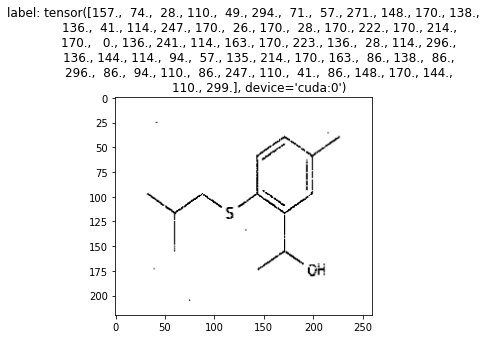

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


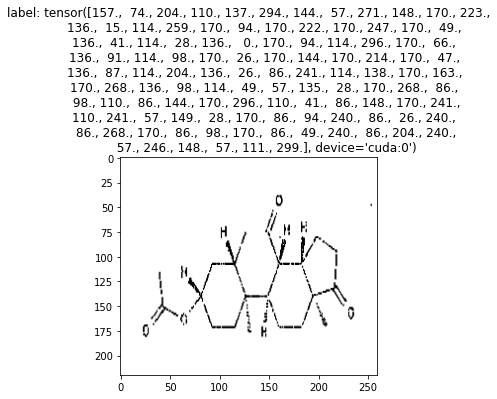

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


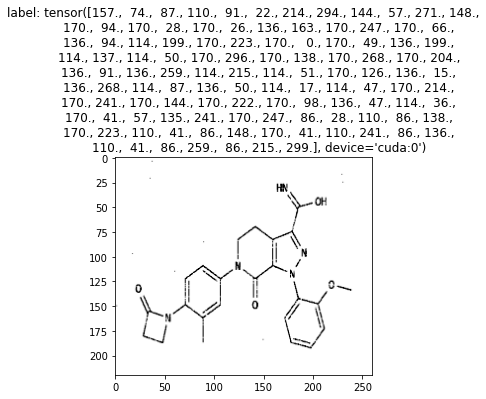

In [ ]:
for i in range(3):
  image,labels,label_lengths = train_dataset[i]
  print(type(image))
    
  plt.imshow(image.transpose(0, 1).transpose(1, 2))
  plt.title(f'label: {labels}')
  plt.show() 

Pad Sequence:

If the length of each sequences in a size 8 batch is different, padding sequence which results in the same length.

In [ ]:
def bms_collate(batch):# collate 
    imgs, labels, label_lengths = [], [], []
    for data_point in batch:
        imgs.append(data_point[0])
        labels.append(data_point[1])
        label_lengths.append(data_point[2])
    labels = pad_sequence(labels, batch_first=True, padding_value=elementCodes.index('-pad-'))
    return torch.stack(imgs), labels, torch.stack(label_lengths).view(-1, 1)

In [ ]:
print(elementCodes.index('-pad-'))
# elementCodes['-pad-']


173


In [ ]:
def dataload(dataset, batch_size):
 tl  = DataLoader(dataset, batch_size, shuffle=True,collate_fn=bms_collate)

 
 for i,(imgs,inchiLabels,inchlength) in enumerate(tl): 
    # print(inchlength)
      # print('next')
    return imgs.to(device), inchiLabels.to(device),inchlength.to(device)

In [ ]:
# imgtrain,inchiLabelstrain,_ = dataload(train_dataset,8)

# for i, labels in enumerate(inchiLabelstrain):
#   # print(labels)



#Encoder
Encoder class takes the input image and converts them into a vector of  much smaller images using pre-trained CNN network. In this case, a pre-trained  resnet34 is being used. The last two layers are removed because this is not a classification task.

In [ ]:
 class Encoder(nn.Module):
    """
    Encoder    
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet34(pretrained=True) 

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """       
        out = self.resnet(images)  
        out = self.adaptive_pool(out)  
        out = out.permute(0, 2, 3, 1)  
        return out

#Decoder Model with Attention
Encoder output is obtained using the class above.
Instead of feeding entire Encoder output to the decoder as input, only certain weights which are relevant are passed. This is computed using attention menchanism. The context vector obtained after passing through attention is then passed to the decoder cell as decoder input.


In [ ]:
class Image_EncoderDecoder_Attention(nn.Module):
    
    def __init__(self, input_size, hidden_size,decoder_size, output_size,verbose=False):
        super(Image_EncoderDecoder_Attention, self).__init__()
      
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.decoder_size = decoder_size       
        self.encoder_rnn_cell = Encoder()        
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(input_size, self.hidden_size)
        self.W = nn.Linear(self.decoder_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)        
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)  
        self.embedding = nn.Embedding(self.output_size, self.hidden_size) 

        self.init_h = nn.Linear(input_size, decoder_size)  
        self.init_c = nn.Linear(input_size, decoder_size)  
        self.drop = nn.Dropout(0.3)
       
        self.verbose = verbose
        
    def forward(self, input,captions, caption_lengths = None, device = 'cpu', ground_truth = None):
      
        # encoder                      
        encoder_outputs = self.encoder_rnn_cell(input.to(device))
        
        batch_size = encoder_outputs.size(0)
                
        encoder_outputs =encoder_outputs.view(batch_size, -1, 512) 
        
        # print('encoder_output shape', encoder_outputs.shape)
                
        h, c = self.init_hidden_state(encoder_outputs) 
        
        decoder_state = h
        # print('decoder_state shape',decoder_state.shape)
       
        decoder_input = torch.zeros(batch_size, 1, self.output_size).to(device)
        # print('decoder_input', decoder_input.shape)

        if caption_lengths== None: # For inference - when we dont know the length, although now have a different method - predict
          max_len = len(elementCodes)
        else:
          max_len = caption_lengths[torch.argmax(caption_lengths)]-1

        captions= captions.long()
        embedding = self.embedding(captions)
        # print(embedding.shape, "embedding")
        
        outputs = []
                
        U = self.U(encoder_outputs)
        # print(U.shape, 'U.shape' )
        predictions = torch.zeros(batch_size, max_len, 300).to(device)
      
        for i in range(max_len):
            batch_size_t = sum([l > i for l in caption_lengths])
                    
            W = self.W(decoder_state[:batch_size_t])
            # print('W shape', W.shape) #W shape torch.Size([8, 512]) torch.Size([8, 1, 512]) W.unsqueeze(1)
            # print(U[:batch_size_t].shape,' u batch shape') #torch.Size([8, 196, 512])
            
            V = self.attn(torch.tanh(U[:batch_size_t] + W.unsqueeze(1)))            
            # print('V', V.shape) # 8,196,1

            attn_weights = F.softmax(V.squeeze(2), dim = 1) # probability which denotes importance of  the vector
            
            attn_applied =encoder_outputs[:batch_size_t] * attn_weights.unsqueeze(2) #multiplying probability with encoder outputs so that network pays attention to relevant vectors 
            attn_applied = attn_applied.sum(dim=1)
                           
            # print(embedding.shape, "embedding") #8 118 512        

            decoder_input = torch.cat((embedding[:batch_size_t,i,:], attn_applied), dim=1).unsqueeze(0) #passing attn_applied to decoder instead of entire encoder outputs
            # print(decoder_input.shape, 'decoder input shape')#([1, 8, 1024])
        
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state[:batch_size_t].unsqueeze(0))               
               
            out = self.h2o(self.drop(decoder_state)) #drop out with probability 0.3
            # out = self.h2o(decoder_state)            
            out = self.softmax(out)   
            predictions[:batch_size_t, i, :] = out
            outputs.append(out)               

            decoder_state = decoder_state.squeeze(0)   
                 
            decoder_input = out.permute(1,0,2)                
        
        return predictions

    def predict(self, input, captions = None, caption_lengths = None, device = 'cpu', ground_truth = None):
        encoder_outputs = self.encoder_rnn_cell(input.to(device))
        
        batch_size = encoder_outputs.size(0)
                
        encoder_outputs =encoder_outputs.view(batch_size, -1, 512)         
               
        h, c = self.init_hidden_state(encoder_outputs) 
        
        decoder_state = h
        # print('decoder_state shape',decoder_state.shape)
       
        decoder_input = torch.zeros(batch_size, 1, self.output_size).to(device)
        # print('decoder_input', decoder_input.shape)

        output_size = self.output_size

        start_tokens = torch.ones(batch_size, dtype=torch.long).to(device) * elementCodes.index('sop')
        embedding = self.embedding(start_tokens)
        max_len = len(elementCodes)
     
        predictions = torch.zeros(batch_size, max_len, output_size).to(device)
       
        U = self.U(encoder_outputs)  
        outputs = []

        for i in range(max_len):
            # print(i)
            W = self.W(decoder_state)
            V = self.attn(torch.tanh(U + W.unsqueeze(1)))

            attn_weights = F.softmax(V.squeeze(2), dim = 1) 
            
            attn_applied =encoder_outputs * attn_weights.unsqueeze(2) 
            attn_applied = attn_applied.sum(dim=1)

            # print(embedding.shape,'embedding shape',attn_applied.shape,'attn_applied shape')
            
            decoder_input = torch.cat((embedding.squeeze(0), attn_applied), dim=1).unsqueeze(0)            
            # print(decoder_input.shape,'decoder_input shape')
            
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state.unsqueeze(0))                     
               
            out = self.h2o(self.drop(decoder_state))  
            # out = self.h2o(decoder_state)            
            out = self.softmax(out)   
            # predictions[:, i, :] = out
            predictions[:, i, :] = out
            outputs.append(out)               

            decoder_state = decoder_state.squeeze(0)   
                 
            decoder_input = out.permute(1,0,2) 
          
            if np.argmax(out.detach().cpu().numpy()) == elementCodes.index('eop'):
                print('eop')
                break
            embedding = self.embedding(torch.argmax(out, -1))
        return predictions

    def init_hidden_state(self, encoder_out):        
        mean_encoder_out = encoder_out.mean(dim=1)        
        h = self.init_h(mean_encoder_out) 
        c = self.init_c(mean_encoder_out)
        return h, c

#Training the model

In [ ]:
def train_batch_imgecd(net, opt, criterion, batch_size, device = 'cpu', teacher_force = True):
   
    net.train().to(device)
    opt.zero_grad()
    imgs, inchiLabels,inchilength = dataload(train_dataset,batch_size)
   
    inchiL, sort_ind = inchilength.squeeze(1).sort(dim=0, descending=True) #to get a 1 D dimension and can be used in pack padded sequence
    inchiLb, sort_ind = inchiLabels.squeeze(1).sort(dim=0, descending=True)
      
    total_loss = 0
    targets = inchiLabels[:,1:].long()
   
    decode_lengths = (inchilength - 1).tolist()
    flatten_list = [j for sub in decode_lengths for j in sub]
     
    outputs = net(imgs,inchiLabels, inchilength, device, ground_truth = inchiLabels if teacher_force else None) 

    # caption= ''
    # for index, output in enumerate(outputs.view(-1, len(elementCodes))):
          
    #       predicted_word_idx = torch.argmax(output)
    #       caption +=elementCodes[predicted_word_idx]
    # print(caption) 
    # print(targets.shape, 'targets shape') #[8, 118]
    # print(outputs.shape, 'output shape') #[8, 118, 300]

    #Pack padded sequence to avoid unecessary computations due to padding.
    scores = pack_padded_sequence(outputs.view(batch_size,-1,len(elementCodes)), (inchiL-1).tolist(), batch_first=True).data
    targets_p= pack_padded_sequence( targets, (inchiL-1).tolist(), batch_first=True).data

    # loss = criterion(torch.stack(outputs).view(-1, len(elementCodes)), targets.view(-1))
    # loss = criterion(outputs.view(-1, len(elementCodes)), targets.view(-1))
    loss = criterion(scores,targets_p)

    loss.backward()       
    opt.step()    

    return loss/batch_size

In [ ]:
def train_setup_imgecd(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
   
    
    for i in range(n_batches):               
        loss_arr[i+1] = (loss_arr[i]*i + train_batch_imgecd(net, opt, criterion, batch_size, device = device, teacher_force =True))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model_cross.pt')
    return loss_arr

In [ ]:
net = Image_EncoderDecoder_Attention(512, 512, 512,len(elementCodes),device)

#Train Setup

Due to GPU constraints, not able to train entire training data set.

Iteration 1499 Loss 0.019826164469122887


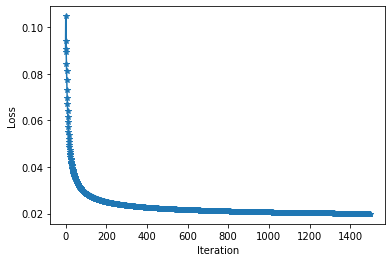

array([0.        , 0.09080072, 0.1048061 , ..., 0.01982684, 0.01982616,
       0.01982525])

In [ ]:
train_setup_imgecd(net, lr=0.01, n_batches=1500, batch_size = 64, display_freq=100, device=device)

In [ ]:
# # net = Image_EncoderDecoder_Attention(512, 512, 512,len(elementCodes),device)
# net= torch.load("model_cross.pt")


#Inference

In [ ]:
def inference(imgs ,inchiLabels, model, device):
    model = model.to(device)
    model.eval()   
    targets = inchiLabels[:,1:].long()

    truecap =''
    for j,tg in enumerate(targets.view(-1)):           
      if elementCodes[tg] =='eop':   
        truecap+='\n'               
      elif  elementCodes[tg] !='-pad-':
         truecap +=elementCodes[tg] 


    print('True captions\n',truecap)

    # imgs, inchiLabels,inchilength = dataload(train_dataset,batch_size)    

    with torch.no_grad(): 
        
        op= model.predict(input=imgs,device=device)       

        caption=''

        for index, output in enumerate(op.view(-1, len(elementCodes))):         
          
          predicted_word_idx = torch.argmax(output)

          if (elementCodes[predicted_word_idx] =='eop'):
            # print(caption)  
            caption+='\n'
          elif (elementCodes[predicted_word_idx] !='-pad-'):
            caption +=elementCodes[predicted_word_idx]
          # print(elementCodes[predicted_word_idx])
        print('Predicted captions\n',caption)

    return caption

In [ ]:
imgs,inchiLabels,_ = dataload(train_dataset,8)

In [ ]:
text = inference(imgs,inchiLabels,net,device)

True captions
 C19H30N2O3/c1-16-4-5-18(24-16)12-21-8-9-22-15-19(14-21)10-17(13-23-19)11-20-6-2-3-7-20/h4-5,17H,2-3,6-15H2,1H3/t17-,19-/m1/s
C13H17N3O/c1-2-17-10-4-8-16-9-7-15-13(16)12-5-3-6-14-11-12/h3,5-7,9,11H,2,4,8,10H2,1H
C43H34N2/c1-31-15-23-36(24-16-31)44(37-25-17-33(18-26-37)32-9-3-2-4-10-32)38-27-19-34(20-28-38)35-21-29-39(30-22-35)45-42-13-7-5-11-40(42)41-12-6-8-14-43(41)45/h3,5-30H,2,4H2,1H
C16H21NO4/c1-2-19-16(18)11-17-7-3-4-13(17)12-5-6-14-15(10-12)21-9-8-20-14/h5-6,10,13H,2-4,7-9,11H2,1H
C15H19Br2N3/c1-4-11-8-12(16)6-7-13(11)18-9-14-15(17)10(3)19-20(14)5-2/h6-8,18H,4-5,9H2,1-3H
C18H22N2O5/c1-24-14-7-3-11(9-15(14)25-2)4-8-17(22)20(12-5-6-12)13-10-16(21)19-18(13)23/h3,7,9,12-13H,4-6,8,10H2,1-2H3,(H,19,21,23)/t13-/m1/s
C19H24N2O2S/c1-2-15-3-5-16(6-4-15)7-8-19(23)21-18-13-17(9-10-20-18)14-24-12-11-22/h3-6,9-10,13,22H,2,7-8,11-12,14H2,1H3,(H,20,21,23
C12H7NO2S/c13-7-9-1-3-11(4-2-9)15-12(14)10-5-6-16-8-10/h1-6,8

Predicted captions
 C17H21N3O2/c1-13-7-8-15(11-14)19-9-5-3-2-4-6-1

In [ ]:
# for param_tensor in net.state_dict():
#     print(param_tensor, "\t", net.state_dict()[param_tensor].size())

#To-Do

>Pre-process image data for better clarity.

>Data parallelism ?

>Try LSTM for better predictions.

>Compute accuracy of the model.



In [ ]:
import gc

# del net
gc.collect()

2153